# Classification Template
v1.0

### Imports

In [2627]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetics for the plots
sns.set(style="whitegrid", palette="muted")

RANDOM_STATE = 101

### Read Functions

In [2628]:
def show_data(df):
    """
    Display the first two and the last two records of a DataFrame
    """
    return pd.concat([df.head(2), df.tail(2)])


def show_missing_data(df):
    """
    Display number and percentage of missing values in all columns
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (
        ((df.isnull().sum() / df.isnull().count()) * 100)
        .sort_values(ascending=False)
        .round(2)
    )
    missing_data = pd.concat([total, percent], axis=1, keys=["# missing", "% missing"])
    print(missing_data)


def show_unique_values(df, fields):
    """
    Show unique values in DataFrame given a list of fields
    """
    for field in fields:
        try:
            print(f"{field}: {df[field].unique()}")
        except KeyError:
            print(f"`{field}` not found in DataFrame")

### Evaluation Functions

In [2629]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)

    print(f'{type(classifier).__name__}:\n')
    print(f"1) classification_report:\n\n", classification_report(y_test, y_pred))
    print(f"2) confusion_matrix:\n\n", confusion_matrix(y_test, y_pred), "\n")
    print(f"3) accuracy_score:\n\n", f'{accuracy_score(y_test, y_pred)*100:.2f}%')

In [2630]:
from sklearn.model_selection import cross_val_score


def evaluate_model_kfold(
    classifiers, _X_train, _X_train_scaled, y_train, models_to_scale, cv=10
):
    """
    TBD
    - Apply to test data to assess the model's ability to generalize to unseen data
      by dividing the training set into k smaller sets
    """
    results = []

    for classifier in classifiers:
        if type(classifier).__name__ in models_to_scale:
            X_train = _X_train_scaled
        else:
            X_train = _X_train

        accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=cv)
        results.append(
            {
                "Model": type(classifier).__name__,
                "Accuracy": accuracies.mean() * 100,
                "SD": accuracies.std() * 100,
            }
        )

    # Sort the results by accuracy in descending order
    sorted_results = sorted(results, key=lambda x: x["Accuracy"], reverse=True)

    # Print the results in a table format
    print(f"{'Model':<25} {'Accuracy %':<12} {'SD %':<10}")
    print("-" * 43)
    for result in sorted_results:
        print(
            f"{result['Model']:<25} {result['Accuracy']:<12.2f} {result['SD']:<10.2f}"
        )

In [2631]:
from sklearn.model_selection import GridSearchCV


def evaluate_model_grid_search_cv(
    classifier, X_train, y_train, params, scoring="accuracy", cv=10, n_jobs=-1
):
    grid_search = GridSearchCV(
        estimator=classifier, param_grid=params, scoring=scoring, cv=cv, n_jobs=n_jobs
    )

    grid_search.fit(X=X_train, y=y_train)

    best_accuracy = grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"Model: {type(classifier).__name__}")
    print(f" - Best accuracy: {best_accuracy * 100:,.2f}%")
    print(f" - Best params: {best_params}")

In [2632]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
):
    """
    Plot a learning curve for an estimator.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    # Calculate means for train and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot the learning curve
    sns.lineplot(x=train_sizes, y=train_scores_mean, label='Training score')
    sns.lineplot(x=train_sizes, y=test_scores_mean, label='Cross-validation score')

    plt.title(f"Learning Curve - {type(estimator).__name__}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

### Write Functions

In [2633]:
from sklearn.impute import SimpleImputer


def update_null_values(df, fields, strategy, fill_value=np.nan):
    """
    Update values with a given strategy.
    `fill_value` is only used when `strategy` = "constant"
    `strategy`:  {'constant', 'most_frequent', 'mean', 'median'}
    """
    try:
        imputer = SimpleImputer(
            missing_values=np.nan, strategy=strategy, fill_value=fill_value
        )
        imputer.fit(df[fields])
        df_transformed = df.copy()
        df_transformed[fields] = imputer.transform(df[fields])
        return df_transformed
    except ValueError as e:
        print(f"❌ Error: {e}")
        return df

In [2634]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


def encode_categorical_data(df, fields, encoder):
    """
    Function to encode categorical data in a DataFrame:
    - OneHot: tbd
    - Dummy: tbd
    - Label: tbd
    @TODO: explain when applying each one
    """
    try:
        if encoder == "OneHot":
            # Create a ColumnTransformer, applying OneHotEncoder to specified fields
            ct = ColumnTransformer(
                transformers=[("encoder", OneHotEncoder(), fields)],
                remainder="passthrough",
            )
            # Apply ColumnTransformer, resulting in an array
            transformed_data = ct.fit_transform(df)
            # Create new column names for the one-hot encoded columns
            encoded_columns = ct.named_transformers_["encoder"].get_feature_names_out(
                fields
            )
            # Combine the new column names with the non-transformed columns
            non_transformed_columns = [col for col in df.columns if col not in fields]
            new_column_names = list(encoded_columns) + non_transformed_columns
            # Create a DataFrame from the transformed data
            df_transformed = pd.DataFrame(
                transformed_data, columns=new_column_names, index=df.index
            )

        elif encoder == "Dummy":
            # Create dummy variables
            dummies = pd.get_dummies(df[fields], drop_first=True)
            # Drop the original fields and concatenate the dummy variables
            df_transformed = pd.concat([df.drop(fields, axis=1), dummies], axis=1)

        elif encoder == "Label":
            df_transformed = df.copy()
            # update original target fields with 0-N categorical values
            for field in fields:
                le = LabelEncoder()
                df_transformed[field] = le.fit_transform(df_transformed[field])
        else:
            print(f"encoder `{encoder}` not found")
            return df

        return df_transformed
    except KeyError as e:
        print(f"❌ Error: {e}")
        return df


In [2635]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


def scale_features(X_train, X_test, fields):
    """
    - Only for non-dummy numerical features
    - For KNN, SVM or Logistic Reg/Linear Reg/NN with Gradient descent optimisation
    - For classification, no need to scale dependent variable
    """
    try:
        # Create copies of the original DataFrames
        X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()

        # Scale only the specified fields
        X_train_scaled[fields] = sc.fit_transform(X_train[fields])
        X_test_scaled[fields] = sc.transform(X_test[fields])

        return X_train_scaled, X_test_scaled
    except Exception as e:
        print(f"❌ Error: {e}")
        return X_train, X_test

### Regression Model Functions

@TODO: include random_state in all models

In [2636]:
from sklearn.linear_model import LogisticRegression


def fit_logistic_regression(
    X_train,
    y_train,
    c=1.0,
    max_iter=1000,
    penalty="l2",
    solver="lbfgs",
):
    lr = LogisticRegression(
        random_state=RANDOM_STATE,
        C=c,
        max_iter=max_iter,
        penalty=penalty,
        solver=solver,
    )
    lr.fit(X_train, y_train)
    return lr

In [2637]:
from sklearn.neighbors import KNeighborsClassifier


def fit_knn(
    X_train,
    y_train,
    algorithm="auto",
    leaf_size=30,
    n_neighbors=5,
    p=2,
    weights="uniform",
):
    knn = KNeighborsClassifier(
        algorithm=algorithm,
        leaf_size=leaf_size,
        n_neighbors=n_neighbors,
        p=p,
        weights=weights,
    )
    knn.fit(X_train, y_train)
    return knn

In [2638]:
from sklearn.svm import SVC


def fit_svc(
    X_train,
    y_train,
    c=1.0,
    degree=3,
    gamma="scale",
    kernel="rbf",
):
    svc = SVC(
        random_state=RANDOM_STATE,
        C=c,
        degree=degree,
        gamma=gamma,
        kernel=kernel,
    )
    svc.fit(X_train, y_train)
    return svc

In [2639]:
from sklearn.naive_bayes import GaussianNB


def fit_nb(
    X_train,
    y_train,
    var_smoothing=1e-9,
):
    nb = GaussianNB(var_smoothing=var_smoothing)
    nb.fit(X_train, y_train)
    return nb

In [2640]:
from sklearn.tree import DecisionTreeClassifier


# TODO: default criterion: gini vs. entropy
def fit_decision_tree(
    X_train,
    y_train,
    criterion="entropy",
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter="best",
):
    dt = DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        criterion=criterion,
        max_depth=max_depth,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        splitter=splitter,
    )
    dt.fit(X_train, y_train)
    return dt

In [2641]:
from sklearn.ensemble import AdaBoostClassifier


def fit_ada_boost(
    X_train,
    y_train,
    estimator=DecisionTreeClassifier(max_depth=1),
    algorithm="SAMME.R",
    learning_rate=1.0,
    n_estimators=50,
):
    ada = AdaBoostClassifier(
        random_state=RANDOM_STATE,
        algorithm=algorithm,
        estimator=estimator,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
    )
    ada.fit(X_train, y_train)
    return ada

In [2642]:
from sklearn.ensemble import RandomForestClassifier


# TODO: default criterion: gini vs. entropy
def fit_random_forest(
    X_train,
    y_train,
    bootstrap=True,
    class_weight=None,
    criterion="entropy",
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
):
    rf = RandomForestClassifier(
        random_state=RANDOM_STATE,
        bootstrap=bootstrap,
        class_weight=class_weight,
        criterion=criterion,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
    )
    rf.fit(X_train, y_train)
    return rf

In [2643]:
from xgboost import XGBClassifier


def fit_xgboost(
    X_train,
    y_train,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.3,
    max_depth=6,
    min_child_weight=1,
    n_estimators=100,
    subsample=1,
):
    xgb = XGBClassifier(
        random_state=RANDOM_STATE,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        n_estimators=n_estimators,
        subsample=subsample,
        use_label_encoder=False,
        # eval_metric="logloss",
    )
    xgb.fit(X_train, y_train)
    return xgb

In [2644]:
from catboost import CatBoostClassifier


def fit_catboost(
    X_train,
    y_train,
    bootstrap_type="MVS",
    border_count=254,
    depth=6,
    eval_metric="Logloss",
    iterations=1000,
    l2_leaf_reg=3,
    learning_rate=0.009,
    subsample=0.8,
):
    cat = CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        bootstrap_type=bootstrap_type,
        border_count=border_count,
        depth=depth,
        eval_metric=eval_metric,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        learning_rate=learning_rate,
        subsample=subsample,
    )
    cat.fit(X_train, y_train)
    return cat

### Data Collection

In [2645]:
df_train = pd.read_csv('../src/v1/07_scikit-learn/filez/titanic_train.csv')
show_data(df_train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q


- `PassengerId`: Unique identification of the passenger.
- `Survived`: Survival (0 = No, 1 = Yes). **Target variable**.
- `Pclass`: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd).
- `Name`: Name of the passenger.
- `Sex`: Sex.
- `Age`: Age in years.
- `SibSp`: # of siblings / spouses aboard the Titanic.
- `Parch`: # of parents / children aboard the Titanic.
- `Ticket`: Ticket number.
- `Fare`: Passenger fare.
- `Cabin`: Cabin number.
- `Embarked`: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

### Exploratory Data Analysis

In [2646]:
# Display DataFrame info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [2647]:
# Display number and percentage of missing values
show_missing_data(df_train)

             # missing  % missing
Cabin              687      77.10
Age                177      19.87
Embarked             2       0.22
PassengerId          0       0.00
Survived             0       0.00
Pclass               0       0.00
Name                 0       0.00
Sex                  0       0.00
SibSp                0       0.00
Parch                0       0.00
Ticket               0       0.00
Fare                 0       0.00


In [2648]:
# Describe statistics on numerical fields
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [2649]:
# show unique values given a list of df fields
show_unique_values(df_train, ['Sex', 'Embarked'])

Sex: ['male' 'female']
Embarked: ['S' 'C' 'Q' nan]


In [2650]:
# show count for each value of field 'Embarked'
df_train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [2651]:
# We'll get the average age per class
print(df_train.groupby('Pclass')['Age'].mean())

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64


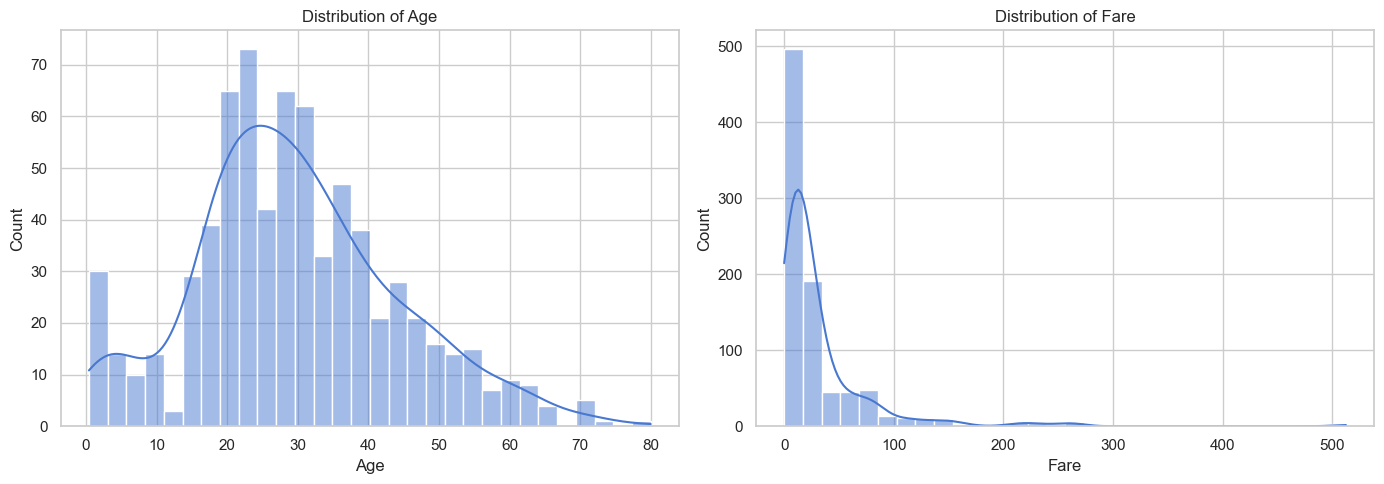

In [2652]:
# Show Age an Fare distributions

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of Age
sns.histplot(df_train['Age'].dropna(), bins=30, ax=ax[0], kde=True)
ax[0].set_title('Distribution of Age')

# Distribution of Fare
sns.histplot(df_train['Fare'], bins=30, ax=ax[1], kde=True)
ax[1].set_title('Distribution of Fare')

plt.tight_layout()
plt.show()

In [2704]:
# Survival by groups of age (in ranges of 10)
pd.crosstab(pd.cut(df_train["Age"], bins=10), df_train["Survived"])

Survived,0,1
Age,,
"(0.34, 8.378]",18,36
"(8.378, 16.336]",27,19
"(16.336, 24.294]",114,63
"(24.294, 32.252]",213,103
"(32.252, 40.21]",82,66
"(40.21, 48.168]",46,24
"(48.168, 56.126]",24,21
"(56.126, 64.084]",15,9
"(64.084, 72.042]",9,0


### Data cleaning & Preprocessing

    TO-BE-REMOVED
- remove or update null values
- manage outliers
- drop irrelevant fields (i.e.: ids, names, ..)
- correct data entry errors

In [2653]:
# Update null values on Age
mean_age_per_class = df_train.groupby('Pclass')['Age'].transform('mean')
df_train['Age'] = df_train['Age'].fillna(mean_age_per_class)

# Update null values on Embarked
df_train = update_null_values(df=df_train, strategy="constant", fields=["Embarked"], fill_value="S")
# equivalent method:
# train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)

# Remove unnecessary fields
df_train = df_train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

### Encoding categorical data

In [2654]:
# OneHot encoder - binary values / keep all values
# df_train = encode_categorical_data(df=df_train, fields=['Embarked', 'Sex'], encoder='OneHot')
# Dummy encoder - binary values / remove first value
df_train = encode_categorical_data(df=df_train, fields=['Embarked', 'Sex'], encoder='Dummy')
# Label encoder - integer values 0-N / keep all values
# df = encode_categorical_data(df=df_train, fields=['Embarked', 'Sex'], encoder='Label')
df_train.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Sex_male
0,0,3,22.0,1,0,7.2500,False,True,True
1,1,1,38.0,1,0,71.2833,False,False,False


In [2655]:
# Reason for using Pclass to fufill missing Age (it has the strongest correlation)
print(df_train.corr(method='pearson')['Age'].abs().sort_values(ascending=False), '\n')

Age           1.000000
Pclass        0.403858
SibSp         0.243452
Parch         0.175799
Fare          0.120886
Sex_male      0.080464
Embarked_Q    0.070315
Survived      0.050504
Embarked_S    0.007400
Name: Age, dtype: float64 



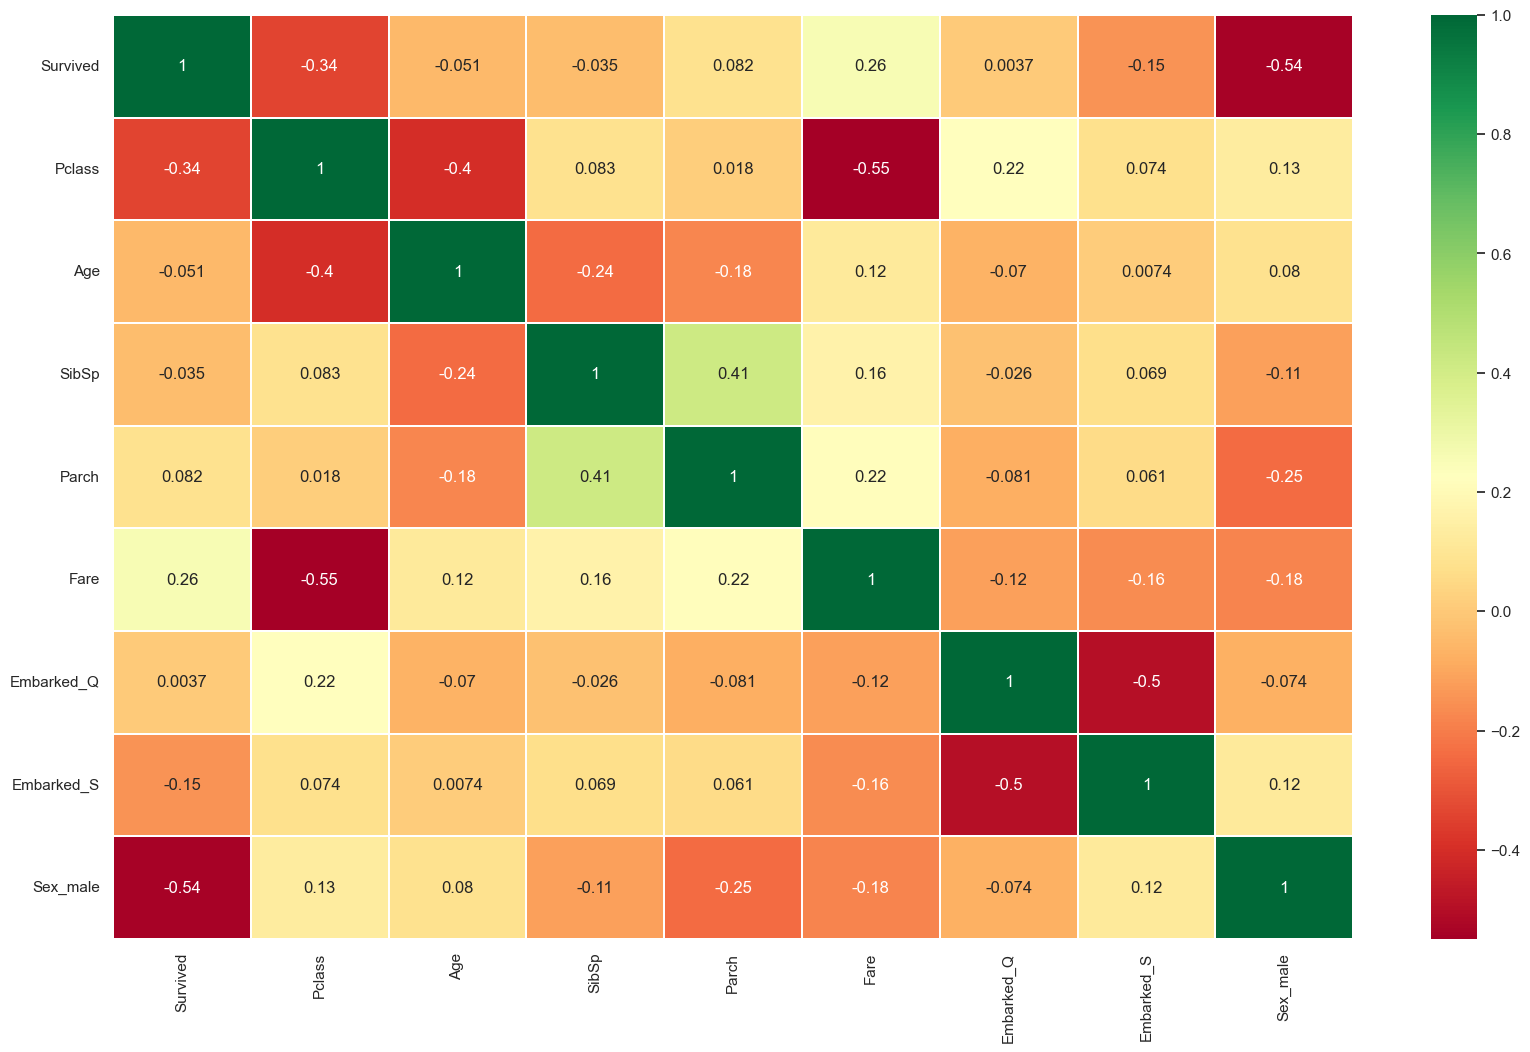

In [2656]:
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

### Splitting dataset into Train/Test set

In [2657]:
from sklearn.model_selection import train_test_split

X = df_train.drop("Survived", axis=1)
y = df_train["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

### Feature scaling

In [2658]:
fields_to_scale = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

X_train_scaled, X_test_scaled = scale_features(
    X_train=X_train, X_test=X_test, fields=fields_to_scale
)

### Fit Models

In [2659]:
# LogReg requires scaling to avoid ConvergenceWarning issue with kfold
# KNN & SVC require scaling
lr = fit_logistic_regression(X_train_scaled, y_train)
knn = fit_knn(X_train_scaled, y_train)
svc = fit_svc(X_train_scaled, y_train)
nb = fit_nb(X_train, y_train)
dt = fit_decision_tree(X_train, y_train)
ada = fit_ada_boost(X_train, y_train)
rf = fit_random_forest(X_train, y_train)
xgb = fit_xgboost(X_train, y_train)
cat = fit_catboost(X_train, y_train)

### Evaluate Models

In [2660]:
models = [lr, knn, svc, nb, dt, ada, rf, xgb, cat]
models_to_scale = ["KNeighborsClassifier", "SVC", "LogisticRegression"]
evaluate_model_kfold(models, X_train, X_train_scaled, y_train, models_to_scale)

Model                     Accuracy %   SD %      
-------------------------------------------
CatBoostClassifier        81.75        5.41      
SVC                       81.60        4.82      
AdaBoostClassifier        80.49        6.65      
RandomForestClassifier    80.33        4.79      
LogisticRegression        80.21        4.86      
XGBClassifier             80.20        3.80      
KNeighborsClassifier      78.37        3.76      
GaussianNB                78.10        5.46      
DecisionTreeClassifier    76.41        4.84      


### Tune Models / Detect Overfitting & Underfitting
- Hyperparameters tunning
- Learning curve to check:
  - **Overfitting** (High Variance): tThe training score is high, but the validation score is significantly lower, indicating that the model fits the training data well but does not generalize to new data.
  - **Underfitting** (High Bias): Both training and validation scores are low, and they converge at a similar low score. This indicates that the model is too simple and does not capture the underlying patterns in the data.

#### Logistic Regresion

In [2707]:
# Logistic Regression

params = {
    "C": [0.01, 0.1, 1, 10, 100],
    "max_iter": [1000],
    "penalty": ["l2"],
    "solver": ["lbfgs", "newton-cg", "sag"],
}

# Feature scaling to avoid ConvergenceWarning issue
evaluate_model_grid_search_cv(lr, X_train_scaled, y_train, params)

Model: LogisticRegression
 - Best accuracy: 80.35%
 - Best params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


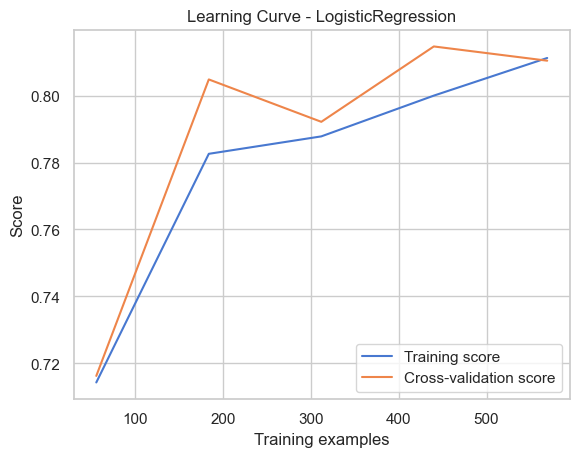

In [2708]:
lr = fit_logistic_regression(X_train_scaled, y_train, 0.1, 1000, "l2", "lbfgs")
plot_learning_curve(lr, X_train_scaled, y_train)


In [2725]:
evaluate_model(lr, X_test_scaled, y_test)

LogisticRegression:

1) classification_report:

               precision    recall  f1-score   support

           0       0.80      0.92      0.85        99
           1       0.88      0.71      0.79        80

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.83      0.83      0.82       179

2) confusion_matrix:

 [[91  8]
 [23 57]] 

3) accuracy_score:

 82.68%


#### KNN

In [2662]:
# KNN

params = {
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [20, 30, 35, 40, 45],
    "n_neighbors": [3, 5, 7, 10],
    "p": [1, 2],
    "weights": ["uniform", "distance"],
}

evaluate_model_grid_search_cv(knn, X_train_scaled, y_train, params)

Model: KNeighborsClassifier
 - Best accuracy: 80.90%
 - Best params: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}


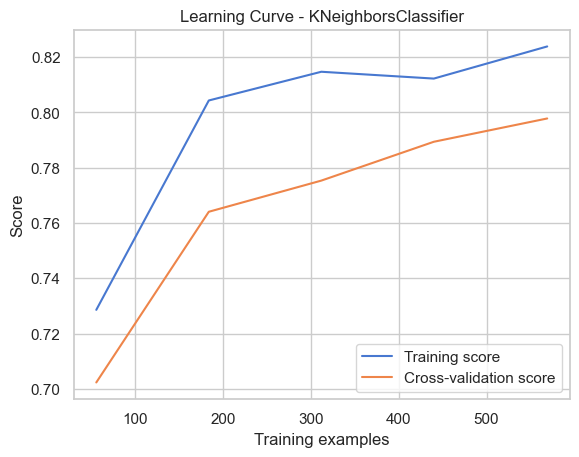

In [2709]:
knn = fit_knn(X_train_scaled, y_train, "auto", 20, 10, 2, "uniform")
plot_learning_curve(knn, X_train_scaled, y_train)
# overfitting

In [2727]:
evaluate_model(knn, X_test_scaled, y_test)

KNeighborsClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.76      0.94      0.84        99
           1       0.89      0.64      0.74        80

    accuracy                           0.80       179
   macro avg       0.83      0.79      0.79       179
weighted avg       0.82      0.80      0.80       179

2) confusion_matrix:

 [[93  6]
 [29 51]] 

3) accuracy_score:

 80.45%


#### SVC

In [2710]:
# SVC

"""
Further options:
- with 'poly' and 'sigmoid' kernels, try 'coef0' ranges -> [0, 1] or [0, 10])
- with 'poly' kernel, try more granular 'degree' ranges
- when dataset is imbalanced (i.e., unequal number of instances in each class),
  try 'class_weight' param
"""

params = {
    "C": [5, 10, 15], # 0.1, 1, 100
    "degree": [1, 2, 3], #4
    "gamma": ["scale", "auto", 1], #  0.1
    "kernel": ["rbf", "poly"], # linear
}

evaluate_model_grid_search_cv(svc, X_train_scaled, y_train, params)



Model: SVC
 - Best accuracy: 81.88%
 - Best params: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


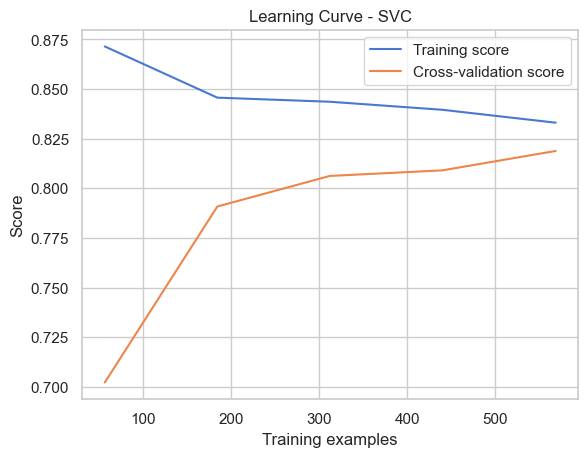

In [2711]:
svc = fit_svc(X_train_scaled, y_train, 10, 2, "scale", "poly")
plot_learning_curve(svc, X_train_scaled, y_train)

In [2728]:
evaluate_model(svc, X_test_scaled, y_test)

SVC:

1) classification_report:

               precision    recall  f1-score   support

           0       0.79      0.92      0.85        99
           1       0.88      0.70      0.78        80

    accuracy                           0.82       179
   macro avg       0.83      0.81      0.81       179
weighted avg       0.83      0.82      0.82       179

2) confusion_matrix:

 [[91  8]
 [24 56]] 

3) accuracy_score:

 82.12%


#### Naive Bayes

In [2712]:
# Gaussian Naive Bayes

params = {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}

evaluate_model_grid_search_cv(nb, X_train, y_train, params)

Model: GaussianNB
 - Best accuracy: 78.24%
 - Best params: {'var_smoothing': 1e-05}


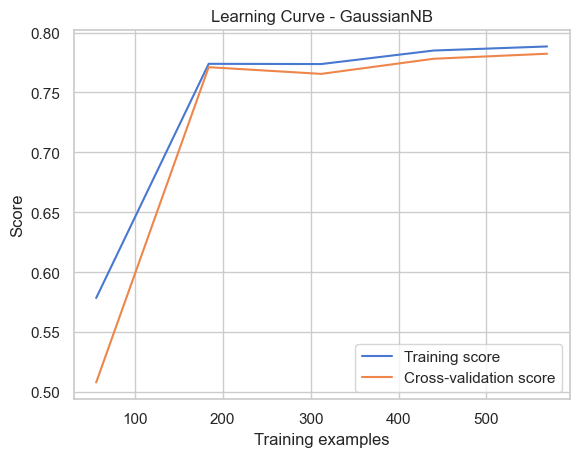

In [2713]:
nb = fit_nb(X_train, y_train, 1e-05)
plot_learning_curve(nb, X_train, y_train)
# clear plateau below 200 records, so model seems too limited for this dataset.

In [2729]:
evaluate_model(nb, X_test, y_test)

GaussianNB:

1) classification_report:

               precision    recall  f1-score   support

           0       0.78      0.91      0.84        99
           1       0.86      0.69      0.76        80

    accuracy                           0.81       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.81      0.81       179

2) confusion_matrix:

 [[90  9]
 [25 55]] 

3) accuracy_score:

 81.01%


#### Decision Tree

In [2714]:
# Decision Tree

params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [10, 20, 30, None],
    "max_features": ["sqrt", "log2", None],
    "max_leaf_nodes": [10, 20, 30, None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "splitter": ["best", "random"],
}

evaluate_model_grid_search_cv(dt, X_train, y_train, params)

Model: DecisionTreeClassifier
 - Best accuracy: 82.73%
 - Best params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


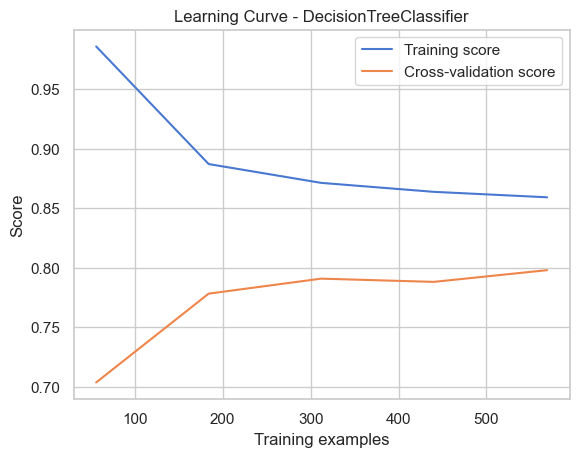

In [2715]:
dt = fit_decision_tree(X_train, y_train, "entropy", 10, "log2", 30, 1, 2, "best")
plot_learning_curve(dt, X_train, y_train)
# overfitting

In [2730]:
evaluate_model(dt, X_test, y_test)

DecisionTreeClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.76      0.96      0.85        99
           1       0.93      0.62      0.75        80

    accuracy                           0.81       179
   macro avg       0.84      0.79      0.80       179
weighted avg       0.83      0.81      0.80       179

2) confusion_matrix:

 [[95  4]
 [30 50]] 

3) accuracy_score:

 81.01%


#### Ada Boost

In [2716]:
# Ada Boost

params = {
    "algorithm": ["SAMME", "SAMME.R"],
    "estimator": [DecisionTreeClassifier(max_depth=depth) for depth in [2, 3, 4]],
    "learning_rate": [0.7, 0.8, 0.9],
    "n_estimators": [240, 250, 260],
}

evaluate_model_grid_search_cv(ada, X_train, y_train, params)

Model: AdaBoostClassifier
 - Best accuracy: 82.87%
 - Best params: {'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.8, 'n_estimators': 250}


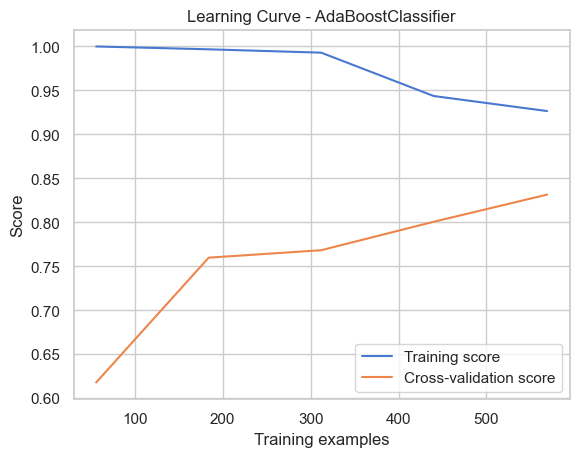

In [2717]:
ada = fit_ada_boost(X_train, y_train, DecisionTreeClassifier(max_depth=3), "SAMME", 0.8, 250)
plot_learning_curve(ada, X_train, y_train)
# moderate overfitting
# since the validation score is increasing, adding more data could improve the model

In [2731]:
evaluate_model(ada, X_test, y_test)

AdaBoostClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.77      0.90      0.83        99
           1       0.84      0.68      0.75        80

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179

2) confusion_matrix:

 [[89 10]
 [26 54]] 

3) accuracy_score:

 79.89%


#### Random Forest

In [2718]:
# Random Forest

params = {
    "bootstrap": [True, False],
    "class_weight": [None], # "balanced"
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 20], # 30, None
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 4], # 2
    "min_samples_split": [5, 10, 15], # 2
    "n_estimators": [20, 30, 40], # 50, 100, 200
}

evaluate_model_grid_search_cv(rf, X_train, y_train, params)

Model: RandomForestClassifier
 - Best accuracy: 83.29%
 - Best params: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}


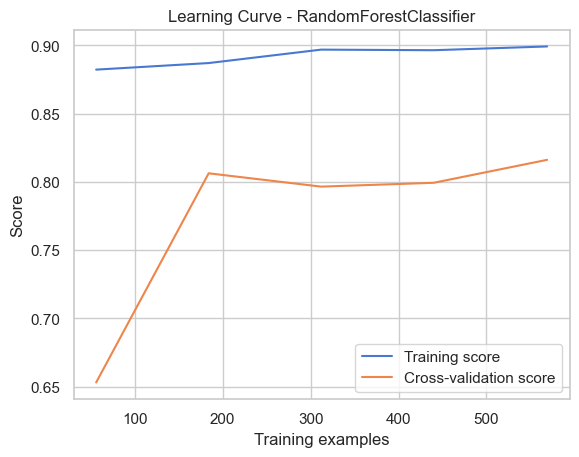

In [2719]:
rf = fit_random_forest(X_train, y_train, True, None, "entropy", 10, "log2", 1, 10, 30)
plot_learning_curve(rf, X_train, y_train)
# - some overfitting
# - cross-validation score is lower and flattens out as more training examples are added, 
#   which does not close the gap with the training score -> the model may not generalize
#   as effectively to unseen data

In [2732]:
evaluate_model(rf, X_test, y_test)

RandomForestClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.77      0.91      0.83        99
           1       0.85      0.66      0.75        80

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.79       179

2) confusion_matrix:

 [[90  9]
 [27 53]] 

3) accuracy_score:

 79.89%


### XGBoost

In [2720]:
# XGBoost
# 84.69%
params = {
    "colsample_bytree": [0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [5, 6, 7],
    "min_child_weight": [3, 5, 6],
    "n_estimators": [100, 125, 150], 
    "subsample": [0.7, 0.8, 0.9],
}

"""
- Gamma: Increase the gamma value to add more regularization. Since your current best is 0.1, 
         consider trying higher values like 0.2, 0.3, or even 0.4.
- Max Depth: Decrease the max_depth to make shallower trees. If the current best is 6,
         you could try values like 4 or 5.
"""

evaluate_model_grid_search_cv(xgb, X_train, y_train, params)

Model: XGBClassifier
 - Best accuracy: 84.69%
 - Best params: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 125, 'subsample': 0.8}


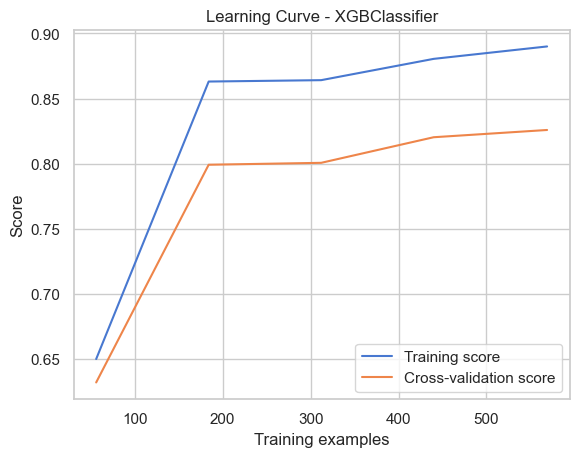

Model                     Accuracy %   SD %      
-------------------------------------------
XGBClassifier             84.13        5.42      


In [2774]:
xgb = fit_xgboost(X_train, y_train, 0.9, 0.4, 0.1, 6, 5, 125, 0.8) # 83.8% on x_test
# xgb = fit_xgboost(X_train, y_train, 0.9, 0.4, 0.05, 6, 5, 250, 0.8) # 83.8% on x_test
plot_learning_curve(xgb, X_train, y_train)
evaluate_model_kfold([xgb], X_train, X_train_scaled, y_train, models_to_scale)
# plateau and some overfitting, though validation increases and more data could improve model

In [2775]:
evaluate_model(xgb, X_test, y_test)

XGBClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.81      0.92      0.86        99
           1       0.88      0.74      0.80        80

    accuracy                           0.84       179
   macro avg       0.85      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

2) confusion_matrix:

 [[91  8]
 [21 59]] 

3) accuracy_score:

 83.80%


#### CatBoost

In [2722]:
# CatBoost

params = {
    "bootstrap_type": ["Bernoulli"],
    "border_count": [32, 64], # 16, 128
    "depth": [3, 4, 5], #  6, 7, 8, 10
    "eval_metric": ["Logloss"],
    "iterations": [200, 225], # 150, 175, 250
    "l2_leaf_reg": [8, 9, 10], # 1, 3, 5, 7
    "learning_rate": [0.1, 0.15, 0.2], # 0.01, 0.05, 0.2
    "subsample": [0.7, 0.8, 0.9], # 0.6
}

evaluate_model_grid_search_cv(cat, X_train, y_train, params)

Model: CatBoostClassifier
 - Best accuracy: 83.58%
 - Best params: {'bootstrap_type': 'Bernoulli', 'border_count': 32, 'depth': 4, 'eval_metric': 'Logloss', 'iterations': 225, 'l2_leaf_reg': 9, 'learning_rate': 0.15, 'subsample': 0.8}


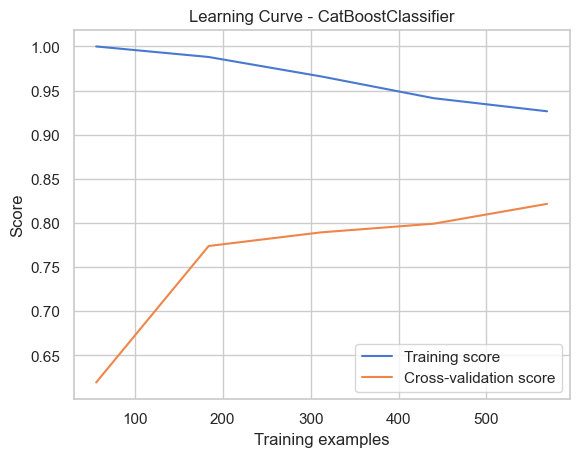

Model                     Accuracy %   SD %      
-------------------------------------------
CatBoostClassifier        83.58        4.48      


In [2723]:
"""
- overfitting: training score super high, through validation score keeps improving.
- solution: either tuning hyperparameters or simplifying the model. 
To improve learning curve:
1) Adjust the depth parameter. A shallower tree might reduce overfitting.
2) Lower the learning_rate to slow down learning and potentially improve generalization.
3) Modify l2_leaf_reg to increase regularization strength.
4) Alter the iterations parameter to find a sweet spot where the model neither
   underfits nor overfits.
5) Experiment with subsample to change the fraction of samples used for fitting each tree.

"""
cat = fit_catboost(X_train, y_train, "Bernoulli", 32, 4, "Logloss", 225, 9, 0.15, 0.8)
plot_learning_curve(cat, X_train, y_train)
evaluate_model_kfold([cat], X_train, X_train_scaled, y_train, models_to_scale)


In [2734]:
evaluate_model(cat, X_test, y_test)

CatBoostClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.82      0.91      0.86        99
           1       0.87      0.75      0.81        80

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

2) confusion_matrix:

 [[90  9]
 [20 60]] 

3) accuracy_score:

 83.80%


When detecting overfitting, "simplifying the model" or "reduce complexity" refers to reducing its capacity to memorize the training data, which is often achieved by lowering the number of parameters or the model's flexibility.

In [2679]:
# Summary
models = [lr, knn, svc, nb, dt, ada, rf, xgb, cat]
evaluate_model_kfold(models, X_train, X_train_scaled, y_train, models_to_scale)

Model                     Accuracy %   SD %      
-------------------------------------------
XGBClassifier             84.69        5.19      
CatBoostClassifier        83.58        4.48      
RandomForestClassifier    83.29        5.05      
AdaBoostClassifier        82.87        4.68      
DecisionTreeClassifier    82.73        3.10      
SVC                       81.88        4.65      
KNeighborsClassifier      80.90        4.56      
LogisticRegression        80.35        4.07      
GaussianNB                78.24        4.78      


In [2680]:
cat.score(X_train, y_train) * 100

92.13483146067416

### Predictions

In [2681]:
# Values to predict
new_data = pd.DataFrame(
    [
        [2, 23, 0, 0, 13, False, True, True],
        [1, 51, 0, 0, 26.5, False, True, True],
        [3, 29, 0, 0, 9.5, False, True, True],
        [1, 40, 1, 1, 134.5, False, False, True],
        [2, 6, 0, 1, 33, False, True, False],
        [3, 19, 0, 0, 14.5, False, True, True],
        [3, 32, 0, 0, 56.4958, False, True, True],
        [1, 41, 0, 0, 134.5, False, False, False],
        [1, 44, 0, 1, 57.9792, False, False, False],
        [3, 29.699118, 8, 2, 69.5500, False, True, False],
    ],
    columns=[
        "Pclass",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked_Q",
        "Embarked_S",
        "Sex_male",
    ],
)

In [2724]:
def make_prediction(
    new_data: pd.DataFrame, model: any, scaled: bool, fields_to_scale: list
):
    """
    TBD
    """
    if scaled and fields_to_scale:
        # Separate the data into features that need scaling and those that don't
        features_to_scale = new_data[fields_to_scale]
        features_not_to_scale = new_data.drop(columns=fields_to_scale)

        # Apply scaling only to the required features
        scaled_features = sc.transform(features_to_scale)

        # Recombine the scaled and unscaled features
        new_data_prepared = pd.concat(
            [
                pd.DataFrame(
                    scaled_features, columns=fields_to_scale, index=new_data.index
                ),
                features_not_to_scale,
            ],
            axis=1,
        )
        new_prediction = model.predict(new_data_prepared)
    else:
        new_prediction = model.predict(new_data)

    print(f"{new_prediction} {type(model).__name__}")

print(f"[{' '.join(map(str, y_train.head(5).tolist() + y_train.tail(5).tolist()))}] y_train")
make_prediction(new_data, xgb, False, fields_to_scale)
make_prediction(new_data, rf, False, fields_to_scale)
make_prediction(new_data, cat, False, fields_to_scale)
make_prediction(new_data, svc, True, fields_to_scale)

[0 1 1 1 1 0 1 1 1 0] y_train
[0 0 0 0 1 0 1 1 1 0] XGBClassifier
[0 1 0 0 1 0 0 1 1 0] RandomForestClassifier
[0 1 0 0 1 0 1 1 1 0] CatBoostClassifier
[0 0 0 0 1 0 0 1 1 0] SVC


### Evaluate Models with (unseen) Test Data
*Only the Top 5*

In [2683]:
evaluate_model(cat, X_test, y_test)

CatBoostClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.82      0.91      0.86        99
           1       0.87      0.75      0.81        80

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

2) confusion_matrix:

 [[90  9]
 [20 60]] 

3) accuracy_score:

 83.80%


In [2684]:
evaluate_model(lr, X_test_scaled, y_test)

LogisticRegression:

1) classification_report:

               precision    recall  f1-score   support

           0       0.80      0.92      0.85        99
           1       0.88      0.71      0.79        80

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.83      0.83      0.82       179

2) confusion_matrix:

 [[91  8]
 [23 57]] 

3) accuracy_score:

 82.68%


In [2685]:
evaluate_model(xgb, X_test, y_test)

XGBClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.80      0.91      0.85        99
           1       0.86      0.71      0.78        80

    accuracy                           0.82       179
   macro avg       0.83      0.81      0.81       179
weighted avg       0.83      0.82      0.82       179

2) confusion_matrix:

 [[90  9]
 [23 57]] 

3) accuracy_score:

 82.12%


In [2686]:
evaluate_model(svc, X_test_scaled, y_test)

SVC:

1) classification_report:

               precision    recall  f1-score   support

           0       0.79      0.92      0.85        99
           1       0.88      0.70      0.78        80

    accuracy                           0.82       179
   macro avg       0.83      0.81      0.81       179
weighted avg       0.83      0.82      0.82       179

2) confusion_matrix:

 [[91  8]
 [24 56]] 

3) accuracy_score:

 82.12%


In [2687]:
evaluate_model(dt, X_test, y_test)

DecisionTreeClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.76      0.96      0.85        99
           1       0.93      0.62      0.75        80

    accuracy                           0.81       179
   macro avg       0.84      0.79      0.80       179
weighted avg       0.83      0.81      0.80       179

2) confusion_matrix:

 [[95  4]
 [30 50]] 

3) accuracy_score:

 81.01%


In [2688]:
evaluate_model(rf, X_test, y_test)

RandomForestClassifier:

1) classification_report:

               precision    recall  f1-score   support

           0       0.77      0.91      0.83        99
           1       0.85      0.66      0.75        80

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.79       179

2) confusion_matrix:

 [[90  9]
 [27 53]] 

3) accuracy_score:

 79.89%


### Conclusion


Selecting the best model involves balancing accuracy, generalizability, and understanding the underlying complexity of the model.

Winner 😁: The `CatBoostClassifier` model shows the 2nd highest accuracy on the test set and a reasonable balance between precision and recall, suggesting a good generalization from training to unseen data.

@TODO: compare accuracy of train vs. test data to check overfitting


TODO: for kaggle submission

### Prepare Test Data

In [2689]:
df_test = pd.read_csv('../src/v1/07_scikit-learn/filez/titanic_test.csv')
show_data(df_test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [2690]:
show_missing_data(df_test)

             # missing  % missing
Cabin              327      78.23
Age                 86      20.57
Fare                 1       0.24
PassengerId          0       0.00
Pclass               0       0.00
Name                 0       0.00
Sex                  0       0.00
SibSp                0       0.00
Parch                0       0.00
Ticket               0       0.00
Embarked             0       0.00


In [2691]:
# Updating null values
# 1) Age
mean_age_per_class = df_test.groupby('Pclass')['Age'].transform('mean')
df_test['Age'] = df_test['Age'].fillna(mean_age_per_class)
# 2) Fare (only 1 record, so using the mean)
df_test = update_null_values(df=df_test, strategy="constant", fields=["Fare"], fill_value=35.627188)

# Encoding categorical data
df_test = encode_categorical_data(df=df_test, fields=['Embarked', 'Sex'], encoder='Dummy')